# Dog Breed classification 🐕
This notebook builds a multi-class dog breed image classifier with TensorFlow 2.7 and TensorFlow Hub .12.

## Problem

Determine the breed of a dog from an image.

Customers want a simple alternative for identifying the breed of their dog.

## Data 

The data is a small subset from Kaggle's "Dog Breed Identification": https://www.kaggle.com/c/dog-breed-identification/overview.

There are 3 labeled dog breeds instead of 120 for right now.

## Evaluation 

The evaluation is a file with prediction probablilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## Features

The data has 60 images in the training set and 60 in the test set of about 6 different dog breeds.


# Git

In [1]:
from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/MyDrive/BreedIdentifier/breedidentifier
%ls -a

!git config --global user.email "madbrow007@gmail.com"
!git config --global user.name {username}

#!git status
#!git reset
#!git remote remove origin 
#!git remote add origin 
#!git remote -v

#!git add .
#!git commit -m "Created validation set and function for preprocessing images"

#!git push origin master


Mounted at /content/drive
/content/drive/MyDrive/BreedIdentifier/breedidentifier
BreedIdentifier.ipynb  new_labels.csv             new_test/
.git/                  new_sample_submission.csv  new_train/


# Setting up environment

In [2]:
# TensorFlow 2.7 and TensorFlow Hub import
import tensorflow as tf
import tensorflow_hub as hub

# Transforming the data (images) into tensors

In [3]:
import pandas as pd
#viewing labels

image_labels = pd.read_csv("/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_labels.csv")
print(image_labels.describe())
print(image_labels.head())

                                      id       breed
count                                 60          60
unique                                60           3
top     087b211f15ad8095ba90c0be54c1c30d  great_dane
freq                                   1          20
                                 id              breed
0  087b211f15ad8095ba90c0be54c1c30d         great_dane
1  058ea5b467d08ed978658dc1ad85fb7d        maltese_dog
2  07bbf36ce2c7407751219804b3d187ec  yorkshire_terrier
3  0b86485ef980b0b4999e7ede1f90999e         great_dane
4  022b34fd8734b39995a9f38a4f3e7b6b        maltese_dog


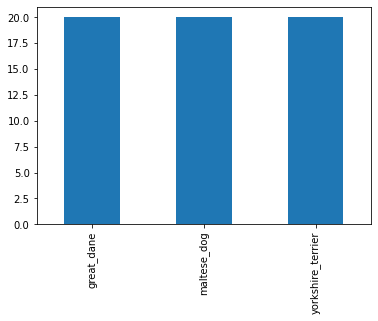

In [4]:
#viewing amount of images per breed on a bar graph
image_labels["breed"].value_counts().plot.bar()

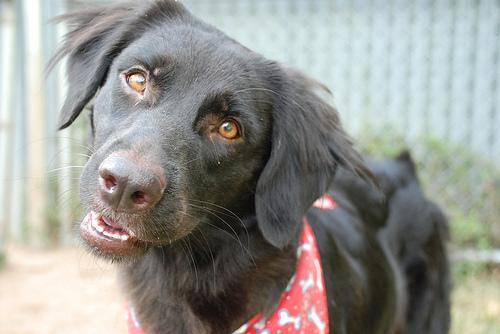

In [5]:
#viewing images

from IPython.display import Image
Image("/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_test/0a342feb5c2100a12bcd15326cf266c6.jpg")



## Listing the images and their labels

In [6]:
import numpy as np
#Filename id list "filenames"
image_paths = ["/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/" + fname  + ".jpg"  for fname in image_labels["id"]]

#viewing
#image_paths[:5]

labels = image_labels["breed"]
labels = np.array(labels)


#boolean array/ boolean array as integer
unique_labels = np.unique(labels)
labels[0] == unique_labels

boolean_labels = [label == unique_labels for label in labels]
boolean_labels[:2]

print(labels[1])
print(np.where(unique_labels == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[1].astype(int))

maltese_dog
(array([0]),)
0
[0 1 0]


#Validation  Set

In [7]:
# file paths to the images
x = image_paths
# boolean numpy label(fileid/breed) representation
y = boolean_labels

# "num_images"
IMAGE_SUBSET = 50 #@param {type:"slider", min:10, max:60, step:5}

In [8]:
from sklearn.model_selection import train_test_split

# DELETE ME.... train_images train_labels
x_train, x_val, y_train, y_val = train_test_split(x[:IMAGE_SUBSET], y[:IMAGE_SUBSET], test_size=0.2, random_state=0)

# x are images and y are labels
len(x_train), len(x_val), len(y_train), len(y_val)

(40, 10, 40, 10)

In [9]:
x_train[:5], y_train[:5]

(['/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/33ca93ae41a388e66586a7795fef8650.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/23418e1e584a9ac9e51c1ab2c804c1a7.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/1548eb783093ac6bdf011d07f3370a36.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/2071036a0cb133584c9b917b1a7e90d7.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/21eec2cb15c5b4948605bf5d2c9ab87e.jpg'],
 [array([ True, False, False]),
  array([False, False,  True]),
  array([False, False,  True]),
  array([False,  True, False]),
  array([ True, False, False])])

## Preprocessing image function

In [ ]:
# image to NumPy array
from matplotlib.pyplot import imread

# For preprocessing each image
def preprocess_image(image_path, image_size = 224):
  """
  Reads in image file and converts it to a tensor
  """

  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[image_size, image_size])

  return image

print(preprocess_image(image_paths[2]))

## Get tuple function

In [11]:
def get_image_tuple(image_path, label):
  """
  returns a tuple with a processed image and a label
  """
  image = preprocess_image(image_path)
  return image, label


## Create batches function

In [24]:
def create_batches(x, y = None, BATCH_SIZE = 32, test_data =False, validation_data = False):
  """
  Creates data batches in sizes of 32 by turning the data to tensor data sets and
  shuffling if training data.
  """

  # test data
  if test_data:
    dataset = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = dataset.map(preprocess_image).batch(BATCH_SIZE)

    print("data batch created for TEST data!")


  # validation data
  elif validation_data:
    dataset = tf.data.dataset.from_tensor_slices(tf.constant(x), tf.constant(y))
    data_batch = dataset.map(get_image_tuple).batch(BATCH_SIZE)

    print("data batch created for VALIDATION data!")


  # training data
  else:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))

    dataset = dataset.shuffle(buffer_size=len(x))

    dataset = dataset.map(get_image_tuple)

    data_batch = dataset.batch(BATCH_SIZE)

    print("data batch created for TRAINING data!")

  return data_batch



train_data = create_batches(x_train, y_train)


data batch created for TRAINING data!


## Visualize data batches function

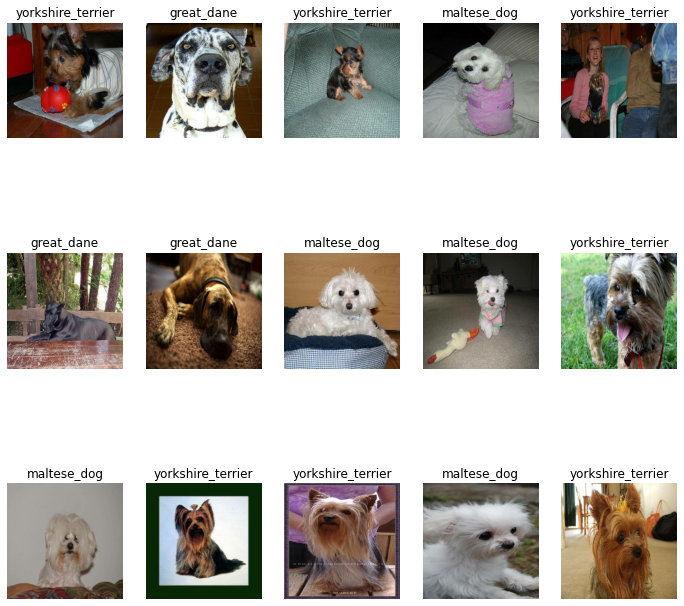

In [32]:
import matplotlib.pyplot as plt

def view_data_batch(images, labels):
  """
  Shows a data batch of images and the labels
  """
  plt.figure(figsize=(12, 12))

  for i in range(15):
    # cretaes 3 rows and 5 columns
    axes = plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[labels[i].argmax()])
    plt.axis("off")

#unbatched the data and turned it into a numpy iterator
x_train, y_train = next(train_data.as_numpy_iterator())

view_data_batch(x_train, y_train)